# Exploratory Data Analysis

## 1. Import & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Iterative Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

# Scaling
from sklearn.preprocessing import RobustScaler

#Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

#Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Cross Validation
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

# Downloading model
import pickle
import json
from google.colab import files
from datetime import datetime



In [2]:
#Load data
df = pd.read_csv('historical_data.csv')

# 2. Preview Data

In [3]:
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


**Insight:**
1. **created_at** and **actual_delivery_time** look like datetime fields → need to confirm type (object vs datetime).






# 3. Duplicates

In [4]:
# Check for duplicates
df[df.duplicated()]
# df[df.duplicated()].value_counts()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration


**Insight: No duplicates in current dataset.**

# 4. Dataset Info

In [5]:
# Info of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

**Intuition:**
1. Shape: **1,97,428 rows × 16 columns**

2. **created_at, actual_delivery_time** → stored as object, should be converted to datetime.

3. Null values present in: **market_id**,  **actual_delivery_time,store_primary_category, order_protocol, total_onshift_dashers**
, **total_busy_dashers, total_outstanding_orders, estimated_store_to_consumer_driving_duration**

5. Non Null columns: **created_at, store_id, total_items, subtotal, num_distinct_items, min_item_price, max_item_price & estimated_order_place_duration**

# 5. Create Target Variable

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_duration_seconds'] = (df['actual_delivery_time']-df['created_at']).dt.total_seconds()
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

**Insight:**
**Target Variable -> delivery_duration_seconds-> Has null values.**

# 6. Unique Values

In [7]:
# check if columns have data inconsistencies
for col in df.columns:
  no_of_unique = df[col].nunique()
  print(f'Number of unique values in {col}: {no_of_unique}')
  if no_of_unique <= 20:
    print(f'Unique values in {col}: {df[col].unique()}')
  print('-'*50)


Number of unique values in market_id: 6
Unique values in market_id: [ 1.  2.  3.  4. nan  5.  6.]
--------------------------------------------------
Number of unique values in created_at: 180985
--------------------------------------------------
Number of unique values in actual_delivery_time: 178110
--------------------------------------------------
Number of unique values in store_id: 6743
--------------------------------------------------
Number of unique values in store_primary_category: 74
--------------------------------------------------
Number of unique values in order_protocol: 7
Unique values in order_protocol: [ 1.  2.  3.  4. nan  5.  6.  7.]
--------------------------------------------------
Number of unique values in total_items: 57
--------------------------------------------------
Number of unique values in subtotal: 8368
--------------------------------------------------
Number of unique values in num_distinct_items: 20
Unique values in num_distinct_items: [ 4  1  5  3

**Insights**:

1. **Categorical fields**: **market_id, store_id, store_primary_category and order_protocol.**
2. **Datetime fields**: **From these, derive useful features like day, hour, weekday/weekend for temporal patterns.**
3. **Numeric fields**: **Remaining columns → numeric (int/float).**

# 7. Missing Data

In [8]:
# Check percentage of missing values in each column
n = len(df)
for col in df.columns:
  val = df[col].isnull().sum()
  per = round(val*100/n,3)
  if val > 0:
    print(f'{col}: {val}-->{per}')

market_id: 987-->0.5
actual_delivery_time: 7-->0.004
store_primary_category: 4760-->2.411
order_protocol: 995-->0.504
total_onshift_dashers: 16262-->8.237
total_busy_dashers: 16262-->8.237
total_outstanding_orders: 16262-->8.237
estimated_store_to_consumer_driving_duration: 526-->0.266
delivery_duration_seconds: 7-->0.004


**Insights**:

1. **Target variable (delivery_duration_seconds)**: Only 7 missing (≈0.004%) → drop records.

2. **market_id, store_primary_category, order_protocol**: <5% missing → impute using mean/median/mode (prefer store-level stats over global).

3. **estimated_store_to_consumer_driving_duration**: <5% missing → impute using mean/median/mode.

4. **total_onshift_dashers, total_busy_dashers, total_outstanding_orders**: ~8% missing → consider ML-based imputation (complex, high priority).


# ***Numerical Columns Analysis***



# 8. Numerical Summary

In [9]:
# Initial Numerical Analysis
numeric_columns = [ 'total_items','subtotal','num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
                   	'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'delivery_duration_seconds'
                   ]
df[numeric_columns].describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
count,197428.000000,197428.000000,197428.000000,197428.000000,197428.000000,181166.000000,181166.000000,181166.000000,197428.000000,196902.000000,1.974210e+05
mean,3.196391,2682.331402,2.670791,686.218470,1159.588630,44.808093,41.739747,58.050065,308.560179,545.358935,2.908257e+03
std,2.666546,1823.093688,1.630255,522.038648,558.411377,34.526783,32.145733,52.661830,90.139653,219.352902,1.922961e+04
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,17.000000,15.000000,17.000000,251.000000,382.000000,2.104000e+03
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2.660000e+03
75%,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3.381000e+03
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,8.516859e+06


**Insights:**

1. Data Discrepancy: Negative values in min_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders.

2. Extreme Outliers: All mentioned numeric columns

3. Skewed columns: All mentioned numeric columns except estimated_store_to_consumer_driving_duration

4. Balanced Column: estimated_store_to_consumer_driving_duration shows near-normal distribution.

# 9. Data Discrepancy Analysis

In [10]:
discrepancy_columns = ['min_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
for col in discrepancy_columns:
  res = df[df[col] < 0]
  print(f'{col}->',end = " ")
  print(f'{len(res)}->', end = " ")
  print(f'{round(len(res)*100/len(df[col]),2)}')
  print('-'*50)

min_item_price-> 13-> 0.01
--------------------------------------------------
total_onshift_dashers-> 21-> 0.01
--------------------------------------------------
total_busy_dashers-> 21-> 0.01
--------------------------------------------------
total_outstanding_orders-> 44-> 0.02
--------------------------------------------------


Insights:
Negative values  in min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders have very low occurrence (<0.05%), hence rows can be safely dropped.

# 10. Distribution of Numeric columns - Visualization Plot

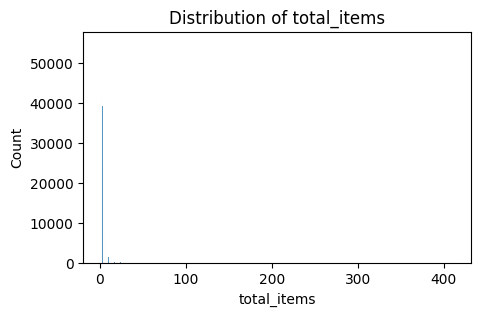

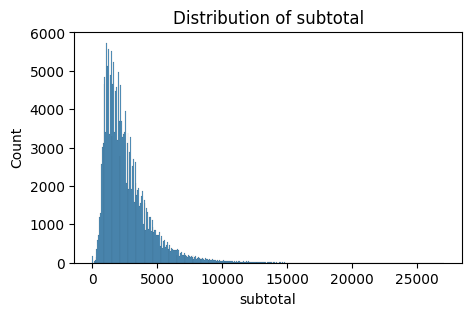

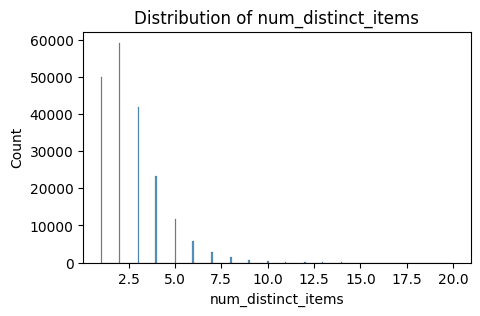

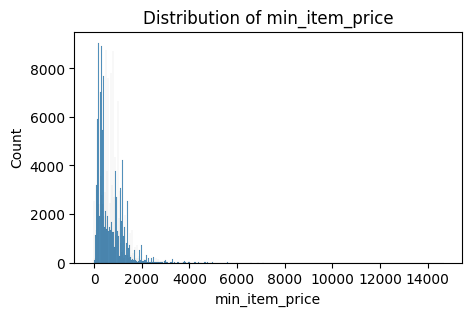

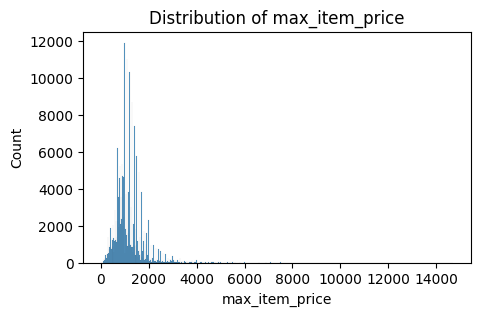

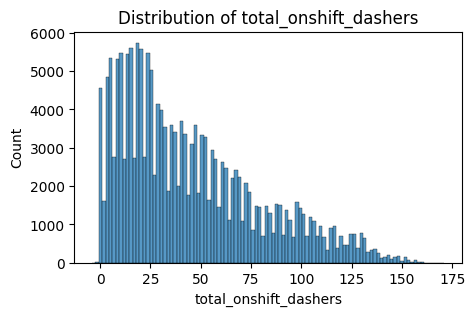

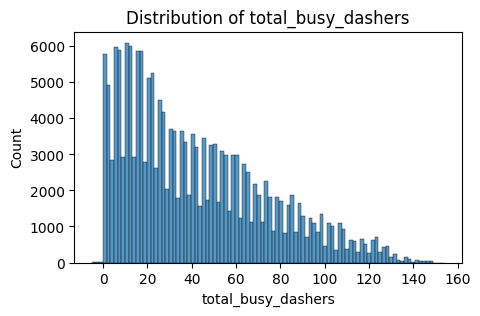

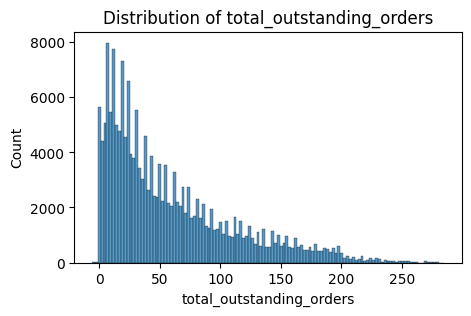

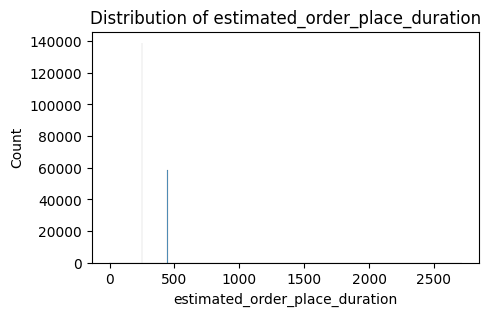

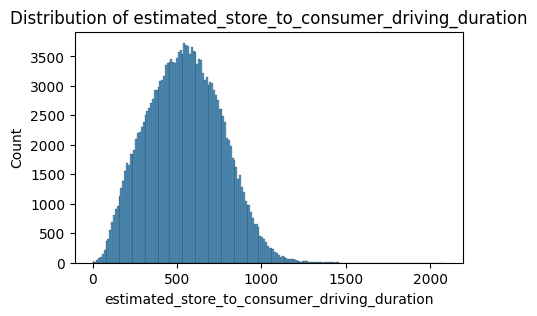

In [11]:
for col in numeric_columns:
  if col!='delivery_duration_seconds':
    plt.figure(figsize=(5,3))
    sns.histplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

**Insights**: Through histograms we can confirm the below scenarios

1. **delivery_duration_seconds**: Appears empty due to extreme outliers (max ≈ 98 days) stretching the axis; actual values lie mostly between 35–55 mins.

2. Most numeric columns show right skewness, except estimated_store_to_consumer_driving_duration.

3. estimated_store_to_consumer_driving_duration shows a nearly balanced (normal) distribution.

**Note: Since most columns are skewed, log transformation and scaling are recommended before modeling.**

# 11. Distribution of Outliers in Numeric columns - Visualization Plot

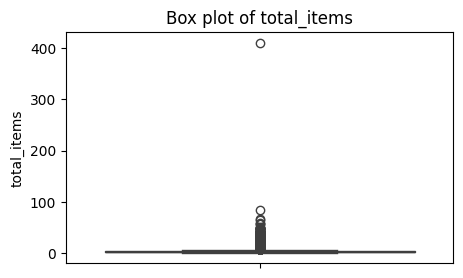

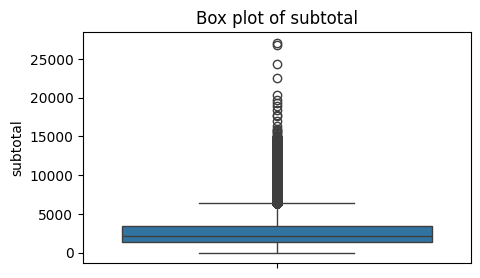

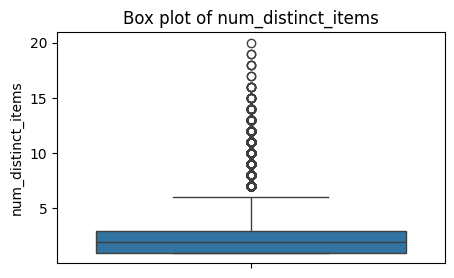

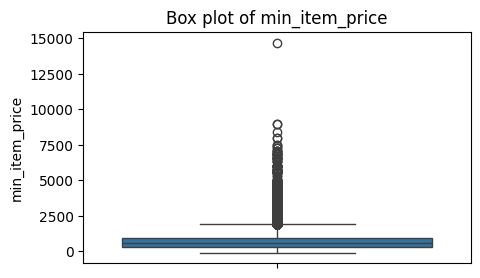

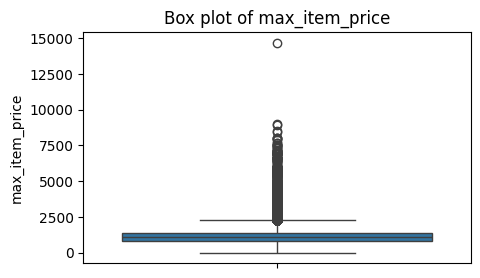

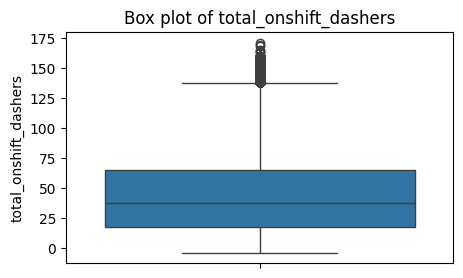

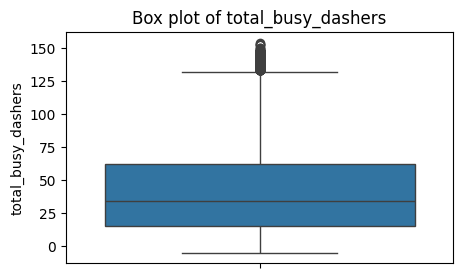

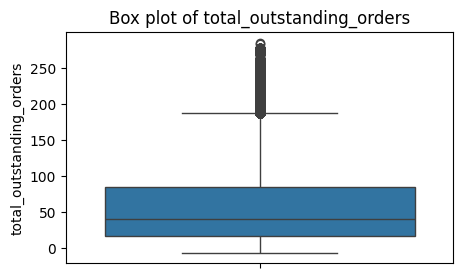

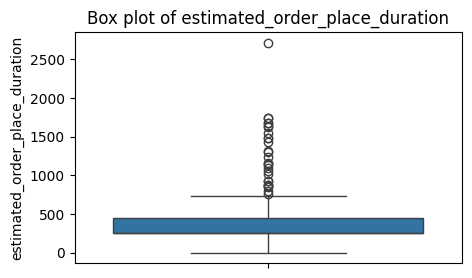

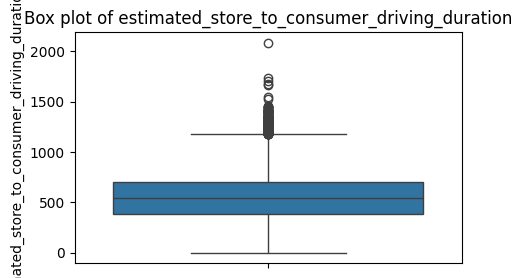

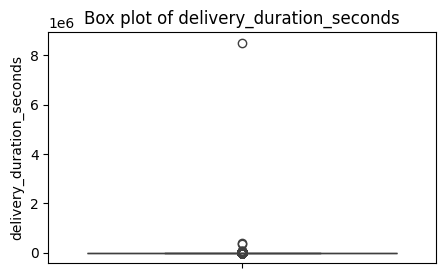

In [12]:
for col in numeric_columns:
  plt.figure(figsize=(5,3))
  sns.boxplot(df[col])
  plt.title(f'Box plot of {col}')
  plt.show()

**Insights**: All numeric columns have outliers.

# 12. Deep Dive of Outliers

In [13]:
for col in numeric_columns:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  outliers = df[(df[col]<lower_bound) | (df[col]>upper_bound)][col]
  print(f'{col}:')
  print(f'  Total outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)')
  print(f'  Range: [{lower_bound:.2f}, {upper_bound:.2f}]')
  print(f'  Min outlier: {outliers.min():.2f}, Max outlier: {outliers.max():.2f}')
  print('-' * 50)


total_items:
  Total outliers: 9588 (4.86%)
  Range: [-1.00, 7.00]
  Min outlier: 8.00, Max outlier: 411.00
--------------------------------------------------
subtotal:
  Total outliers: 9054 (4.59%)
  Range: [-1592.50, 6387.50]
  Min outlier: 6388.00, Max outlier: 27100.00
--------------------------------------------------
num_distinct_items:
  Total outliers: 5919 (3.00%)
  Range: [-2.00, 6.00]
  Min outlier: 7.00, Max outlier: 20.00
--------------------------------------------------
min_item_price:
  Total outliers: 4600 (2.33%)
  Range: [-676.00, 1924.00]
  Min outlier: 1925.00, Max outlier: 14700.00
--------------------------------------------------
max_item_price:
  Total outliers: 7729 (3.91%)
  Range: [-92.50, 2287.50]
  Min outlier: 2289.00, Max outlier: 14700.00
--------------------------------------------------
total_onshift_dashers:
  Total outliers: 1502 (0.76%)
  Range: [-55.00, 137.00]
  Min outlier: 138.00, Max outlier: 171.00
-------------------------------------------

Insights:
1. total_items has an extreme outlier - 411, need to check this data point more specifically.
2. same with min_item_price and max_item_price which has extreme outlier as 14700
3. Target variable(delivery_duration_seconds) has an extreme outlier(8516859.00-98days) need to analyse it carefully

**a. Analysis of outliers in target variable(delivery_duration_seconds)**

In [14]:
p99_delivery_duration = df['delivery_duration_seconds'].quantile(0.99)
print(f"99th percentile: {round(p99_delivery_duration/3600,3)}hrs")

99th percentile: 1.799hrs


Insight: Based on business understanding of  delivery times in market, orders with delivery time less than 5mins and greater than 3hours are treated as outliers.

In [15]:
# Delivery time less than 5mins
very_quick_orders = df[df['delivery_duration_seconds']<300] #5mins
very_quick_orders.sort_values(by='delivery_duration_seconds', ascending=False)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
30562,2.0,2015-02-08 23:21:13,2015-02-08 23:26:10,6865,mexican,5.0,1,1499,1,799,799,67.0,58.0,61.0,251,417.0,297.0
862,2.0,2015-01-25 21:59:08,2015-01-25 22:02:51,1904,sandwich,2.0,1,1195,1,1195,1195,60.0,74.0,51.0,251,218.0,223.0
63294,2.0,2015-01-24 23:52:55,2015-01-24 23:54:36,4210,mexican,2.0,3,1455,2,355,745,44.0,48.0,40.0,251,275.0,101.0


**Insight:**

The 3 records with delivery time < 5 minutes are all from market_id = 2. These appear to be data quality issues because:
- (estimated_order_place_duration + estimated_store_to_consumer_driving_duration) totals ~700-800 seconds
- But actual delivery_duration_seconds shows only 100-223 seconds
- This violates causal logic - actual delivery cannot be faster than the sum of its component estimates
- Given the negligible volume (0.0015% of data) and localized pattern, these records were removed and in real world will be flagged for upstream data quality review.

In [16]:
# Delivery time greater than 3hrs
large_time_orders = df[df['delivery_duration_seconds']>10800]
large_time_orders.sort_values(by='delivery_duration_seconds', ascending=False)

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,1595,NaN,NaN,NaN,446,412.0,8516859.0
185550,4.0,2015-01-28 08:34:06,2015-02-01 16:25:25,6503,dessert,5.0,3,1520,3,220,750,0.0,0.0,0.0,251,476.0,373879.0
27189,1.0,2015-02-16 02:24:09,2015-02-19 22:45:31,4338,indian,3.0,4,4980,4,995,1795,72.0,68.0,104.0,251,767.0,332482.0
83055,2.0,2015-02-01 02:18:07,2015-02-01 18:08:39,355,burger,4.0,3,2379,2,389,695,109.0,102.0,163.0,251,602.0,57032.0
190860,1.0,2015-02-16 02:31:05,2015-02-16 17:38:32,2169,indian,3.0,4,3660,4,375,1195,71.0,70.0,111.0,251,326.0,54447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172531,3.0,2015-01-27 01:26:05,2015-01-27 04:27:17,5135,middle-eastern,4.0,11,4694,6,25,1499,3.0,3.0,3.0,446,422.0,10872.0
10579,5.0,2015-01-23 04:55:18,2015-01-23 07:56:26,410,middle-eastern,5.0,2,2700,2,1100,1600,19.0,6.0,6.0,251,662.0,10868.0
86557,1.0,2015-02-02 02:09:56,2015-02-02 05:10:51,2153,chinese,1.0,6,7970,5,695,2295,18.0,20.0,28.0,446,675.0,10855.0
82866,4.0,2015-02-17 19:35:21,2015-02-17 22:35:56,3086,asian,3.0,2,1050,2,475,475,0.0,0.0,0.0,446,818.0,10835.0


Insight:Very less percenatage of records i.e 138 out of 1 lakh records have delivery time greater than 3hours, so we can drop these records.

**b. outlier deep dive in numeric features- lets concentrate only on extreme cases**

In [17]:
# For total_items there is an extreme outlier where total_items value is 411
df[df['total_items']==411]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
47231,2.0,2015-02-06 00:42:39,2015-02-06 01:33:34,777,fast,4.0,411,3115,5,0,299,35.0,35.0,39.0,251,573.0,3055.0


Insight: We can remove this record with extreme outlier for total_items

In [18]:
# For min_item_price and max_item_price extreme outlier analysis
df[df['min_item_price']==14700]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
139718,3.0,2015-02-04 01:35:22,2015-02-04 03:02:37,2580,breakfast,5.0,1,14700,1,14700,14700,23.0,21.0,22.0,251,934.0,5235.0


In [19]:
df[df['max_item_price']==14700]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds
139718,3.0,2015-02-04 01:35:22,2015-02-04 03:02:37,2580,breakfast,5.0,1,14700,1,14700,14700,23.0,21.0,22.0,251,934.0,5235.0


Insight: We can remove these extreme outliers in min_item_price and max_item_price.

# ***Categorical Columns Analysis***



# 13. Mapping Between market_id & store_id

In [20]:
duplicate_stores = df.groupby('store_id')['market_id'].nunique()
stores_with_multiple_markets = duplicate_stores[duplicate_stores > 1]
stores_with_multiple_markets

,market_id
store_id,
4,4
9,2
16,4
17,3
19,2
...,...
6971,2
6973,2
6979,2


**Insight:**
1. store_id not globally unique (appears in multiple market_ids).
2. Feature engineering: use combined key market_store_id.

# 14. Temporal Patterns

In [21]:
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['day'] = df['created_at'].dt.day
df['hour'] = df['created_at'].dt.hour
df['dayofweek'] = df['created_at'].dt.dayofweek
# df[['year','month','day','hour','dayofweek','created_at']]

# 15. Distribution of Categories

In [22]:
categorical_columns = ['market_id', 'store_id', 'store_primary_category', 'order_protocol', 'year', 'month', 'day', 'hour', 'dayofweek']
n = len(df)
for col in categorical_columns:
  res = pd.DataFrame(df[col].value_counts())
  res['per'] = res['count']*100/n
  print(res)
  print('-'*50)

           count        per
market_id                  
2.0        55058  27.887635
4.0        47599  24.109549
1.0        38037  19.266264
3.0        23297  11.800251
5.0        18000   9.117248
6.0        14450   7.319124
--------------------------------------------------
          count       per
store_id                 
6865        937  0.474603
1311        863  0.437121
314         815  0.412809
1686        765  0.387483
3937        721  0.365196
...         ...       ...
6907          1  0.000507
6661          1  0.000507
1193          1  0.000507
6115          1  0.000507
2273          1  0.000507

[6743 rows x 2 columns]
--------------------------------------------------
                        count       per
store_primary_category                 
american                19399  9.825861
pizza                   17321  8.773325
mexican                 17099  8.660879
burger                  10958  5.550378
sandwich                10060  5.095528
...                       ...  

**Insight:**
1. Combine market_id and store_id  to have a new column.
2. Year column with 2014 has only one record, so we can drop that record and also drop year column because it will only 2015 value.
3. If the data you have is non-linear data and you decided to use tree based models, then the mentioned categorical features can be simply encoded using label encoding, if the data is nearly linear and you are going with linear models then complex encoding like one-hot , target encoding should be explored.

In [23]:
df[df['year']==2014]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,year,month,day,hour,dayofweek
2690,1.0,2014-10-19 05:24:15,2015-01-25 19:11:54,3560,italian,1.0,1,1695,1,1595,...,NaN,NaN,446,412.0,8516859.0,2014,10,19,5,6


Insight: Remove the 2014 record its just one.

# 16. Visualizations of Categorical Variables

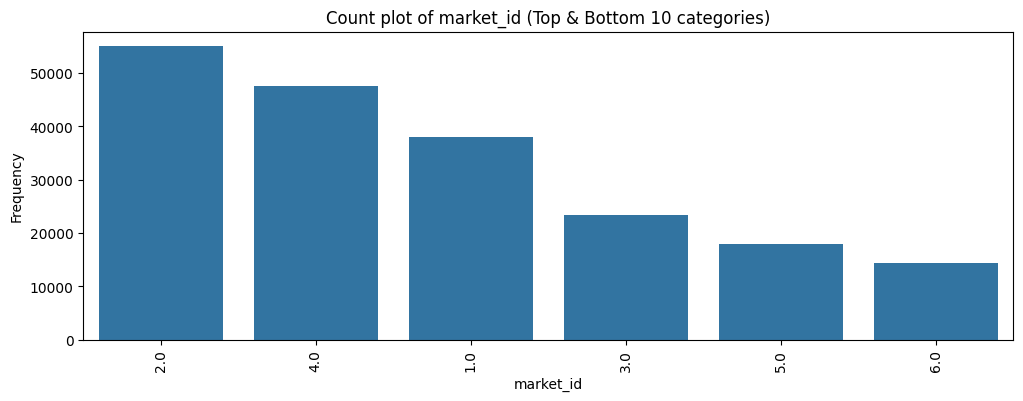

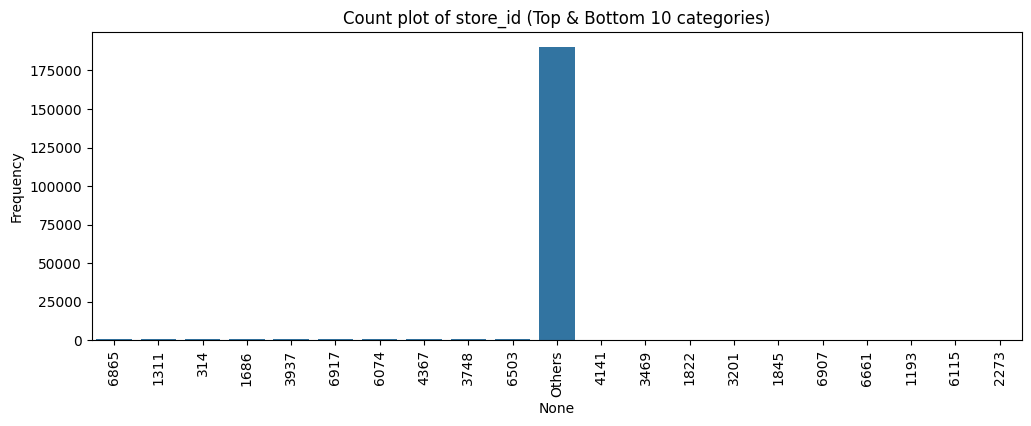

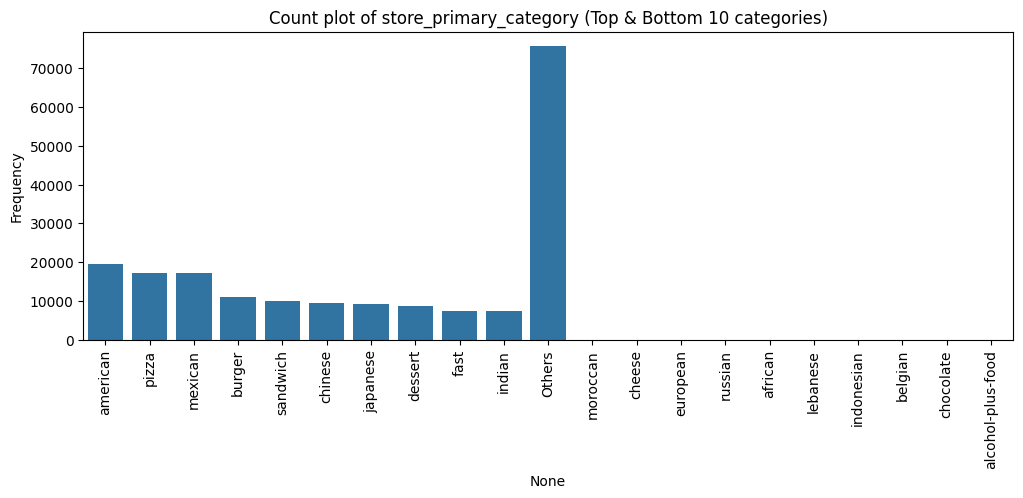

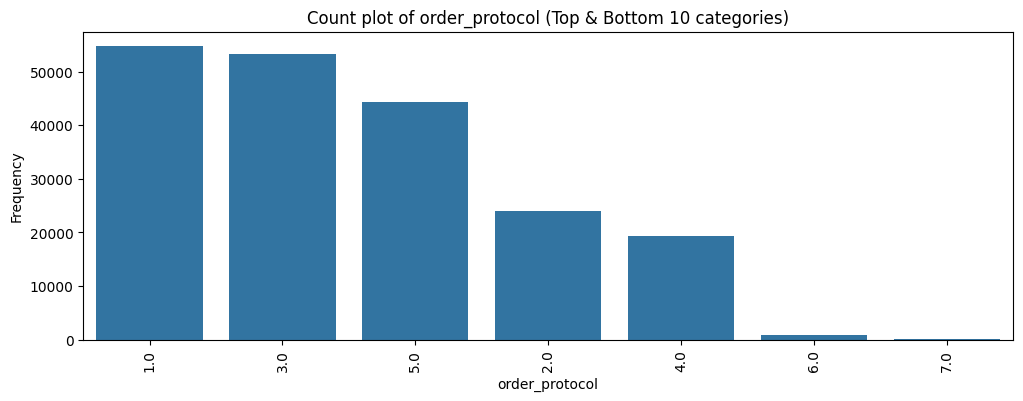

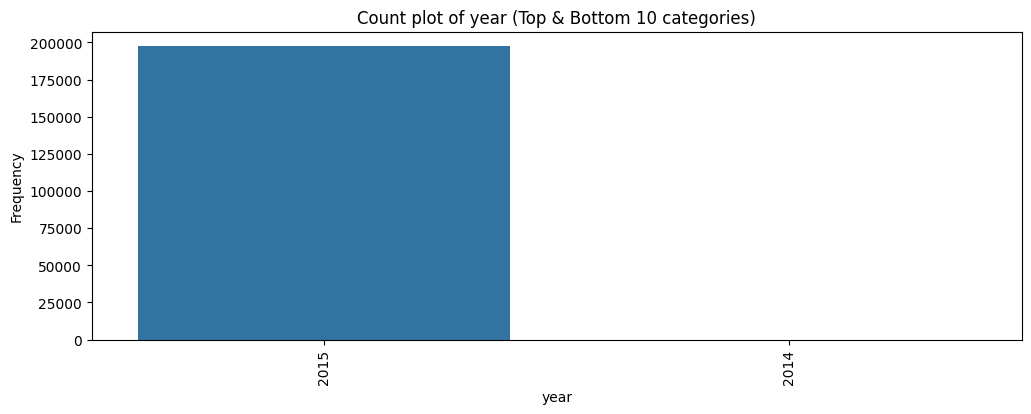

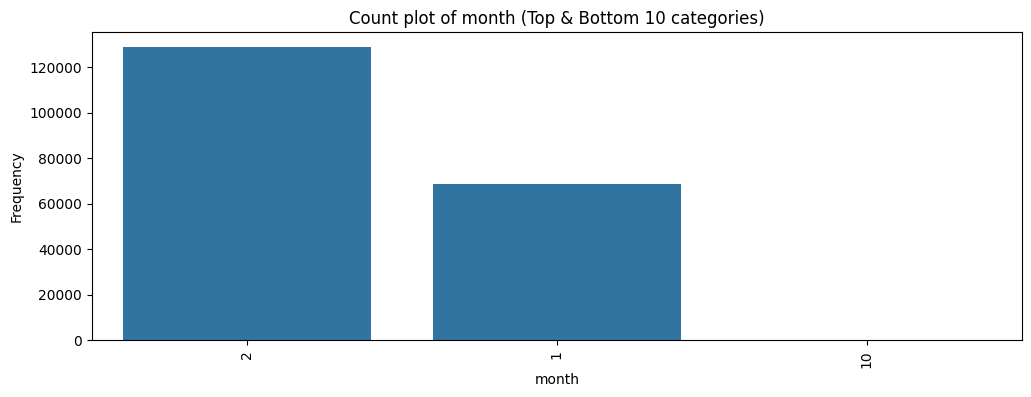

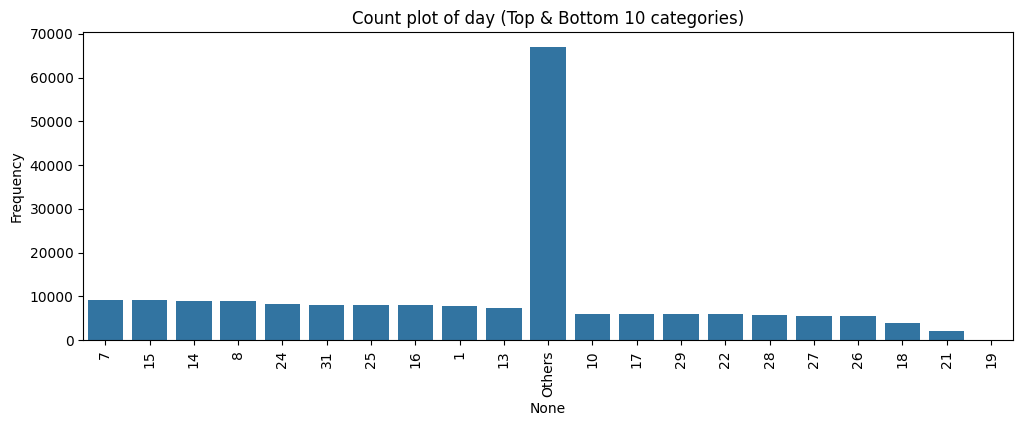

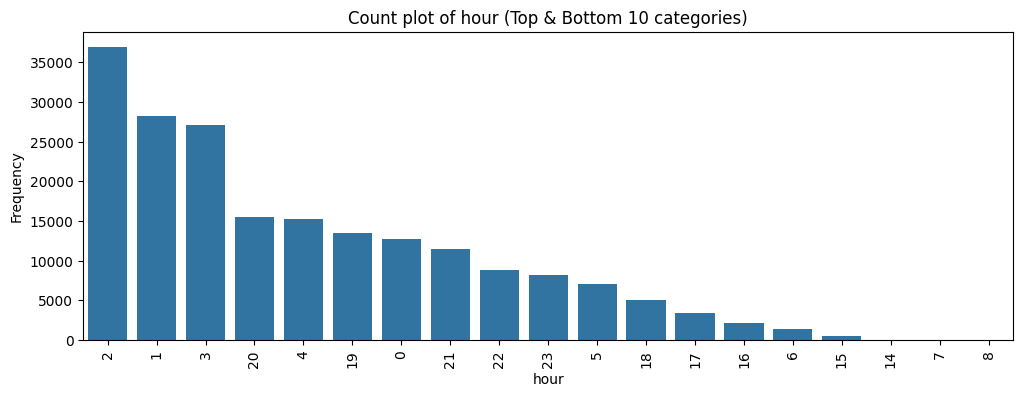

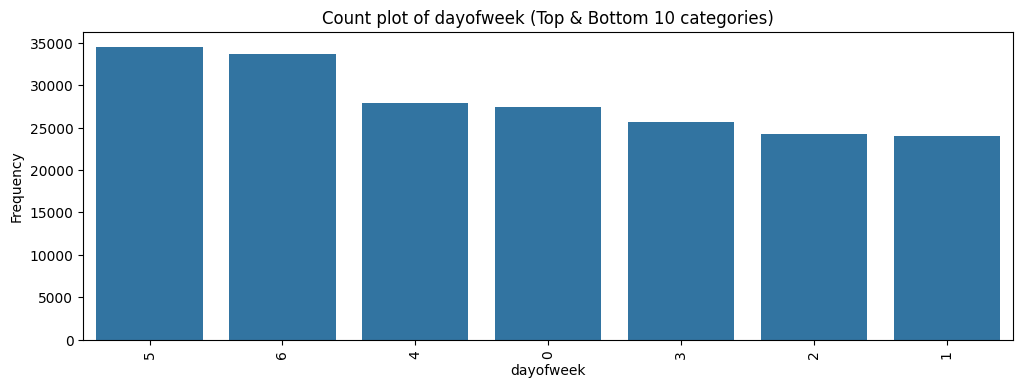

In [24]:
def plot_categorical_counts(df, col, top_n=10):
    counts = df[col].value_counts()

    # If too many categories, show top + bottom + collapse middle
    if len(counts) > top_n * 2:
        top = counts.head(top_n)
        bottom = counts.tail(top_n)
        others = pd.Series({"Others": counts.iloc[top_n:-top_n].sum()})
        counts = pd.concat([top, others, bottom])

    plt.figure(figsize=(12,4))
    sns.barplot(x=counts.index, y=counts.values, order=counts.index)
    plt.xticks(rotation=90)
    plt.title(f"Count plot of {col} (Top & Bottom {top_n} categories)")
    plt.ylabel("Frequency")
    plt.show()


for col in categorical_columns:
    plot_categorical_counts(df, col, top_n=10)




# 17. Correlation Analysis

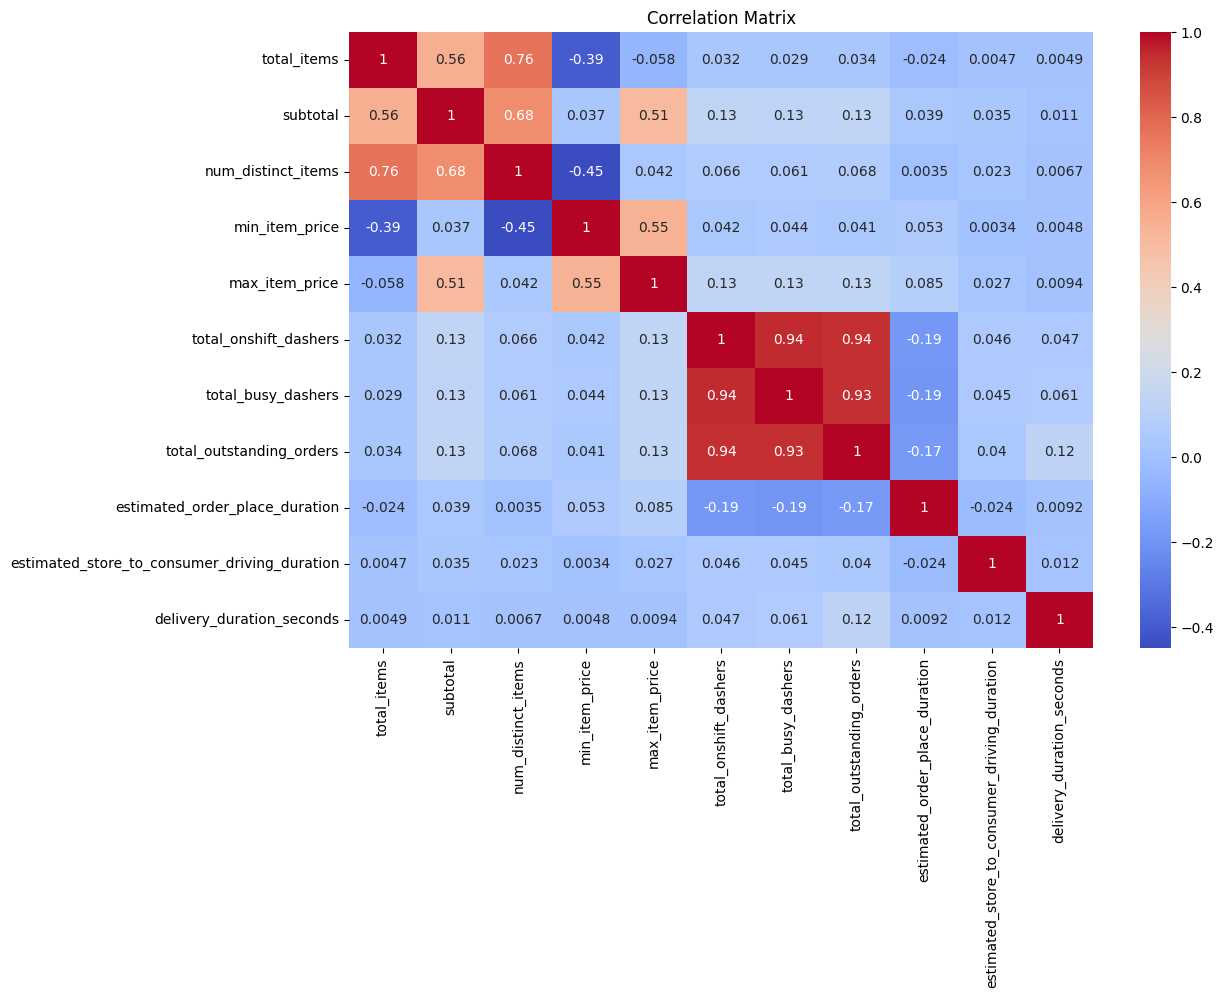

In [25]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(),annot=True,  cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Insights:
1. total_items, sub_total & num_distinct_items are highly postively correlated
2.  total_onshift_dashers, total_busy_dashers and total_outstanding_dashers are very highly  postively correlated
3. Among all other numeric features the feature total_outstanding_dashers has high correlation with target- delivery_duration_seconds

# 18. Feature-Target Relationships

**Numeric Features Vs Target Variable**

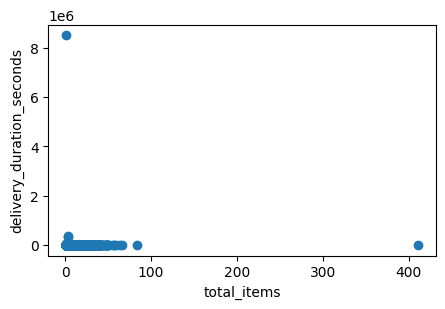

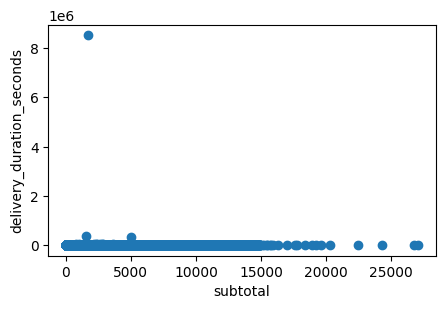

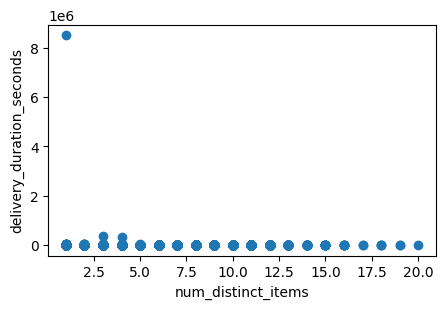

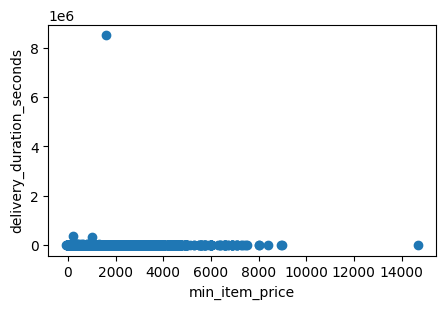

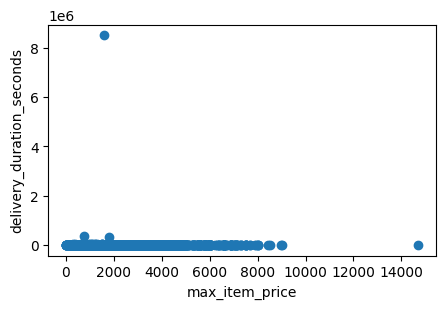

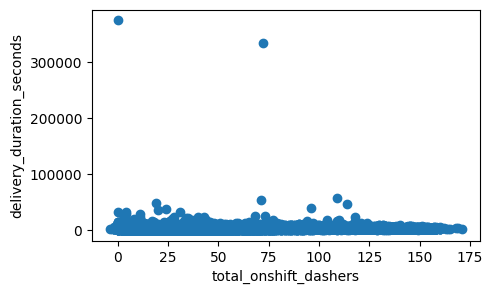

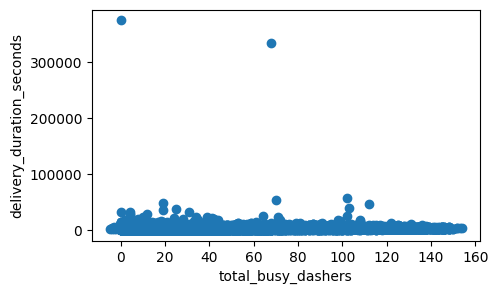

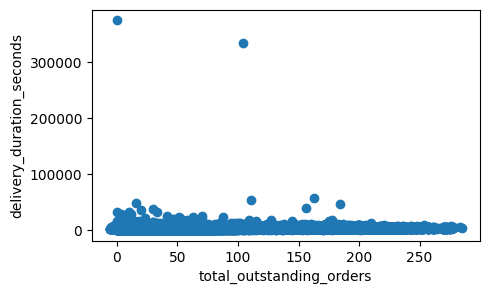

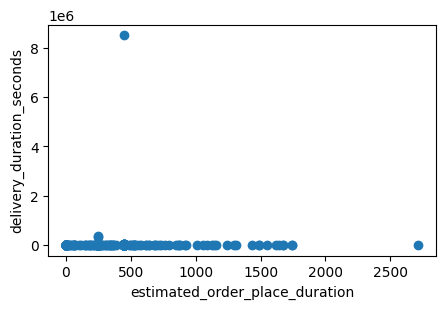

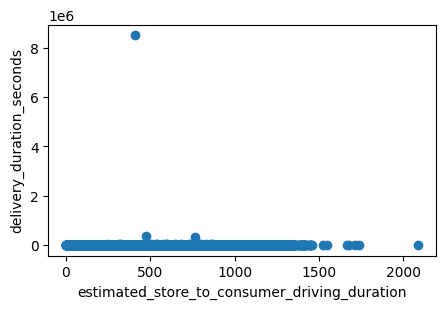

In [26]:
numeric_features = [ 'total_items','subtotal','num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
                   	'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration'
                   ]
for col in numeric_features:
  plt.figure(figsize=(5,3))
  plt.scatter(df[col],df['delivery_duration_seconds'])
  plt.xlabel(col)
  plt.ylabel('delivery_duration_seconds')
  plt.show()

Insight:
1. Relationship b/w features and target looks non-linear

# **Next Steps:**


1. First remove 2014 year record from the dataset.
2. Remove data discrepancy rows like rows with negative values in min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders.
3. Handle below outlier scenarios

   a. Remove records with delivery_duration_seconds less than 5mins or greater than 3 hours.

   b. Remove record where total_item is 411 which is extreme outlier
   
   c. Remove record where the min_item_price and max_item_price has extreme outlier as 14700.
4. Handle missing values, follow below steps

   a. Target variable (delivery_duration_seconds): Only 7 missing (≈0.004%) → drop records.

   b. market_id, store_primary_category, order_protocol & estimated_store_to_consumer_driving_duration: <5% missing → impute using mean/median/mode (prefer store-level stats over global)

   c. total_onshift_dashers, total_busy_dashers, total_outstanding_orders: ~8% missing → consider ML-based imputation (complex, high priority).

5. As part of Feature Engineering

   a. Combine market_id and store_id to a single column

   b. Most of numeric columns are right skewed, log transform and scale the features.

   c. target variable should also be log transformed and scaled.

   d. As we decided to use tree based model, to keep simple we will encode categorical features using label encoding.

   e. As total_onshift_dashers, total_busy_dashers and total_outstanding_dashers are very highly postively correlated we can go with
   1. busy_dasher_ratio = total_busy_dashers / (total_onshift_dashers + 1)
   2. orders_per_dasher = total_outstanding_orders / (total_onshift_dashers + 1)
   
   This can capture marketplace load with fewer, more meaningful variables and reduce model redundancy.

# Data Cleaning

## Handling Data Discrepancy records

In [27]:
#First remove 2014 year record from the dataset.
# df[df['year']==2014] - Only one record
df = df[~(df['year']==2014)]
# df['year'].value_counts()
df.drop(columns=['year'], inplace=True)

Insight: There was only one record from 2014, which was removed. After this, the year column contained only a single unique value (2015) across all records, providing no variance. Therefore, the year column was dropped as it does not contribute any useful information for analysis.

In [28]:
#Remove data discrepancy rows like rows with negative values in min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders.
# df[df['min_item_price']<0] - Only 13 records
df = df[~df['min_item_price']<0]
df[df['min_item_price']<0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [29]:
# pd.set_option("display.max_columns", None)
# df[df['total_onshift_dashers']<0]  Only 21 records
df = df[~(df['total_onshift_dashers']<0)]
df[df['total_onshift_dashers']<0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [30]:
# len(df[df['total_busy_dashers']<0]) #20 records
df = df[~(df['total_busy_dashers']<0)]
df[df['total_busy_dashers']<0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [31]:
# len(df[df['total_outstanding_orders']<0]) #40 records
df = df[~(df['total_outstanding_orders']<0)]
df[df['total_outstanding_orders']<0]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


Insight: Removed data discrepancy rows containing negative values in min_item_price, total_onshift_dashers, total_busy_dashers, and total_outstanding_orders.

## Handling Outliers

Handle below outlier scenarios

a. Remove records with delivery_duration_seconds less than 5mins or greater than 3 hours.

b. Remove record where total_item is 411 which is extreme outlier

c. Remove record where the min_item_price and max_item_price has extreme outlier as 14700.

In [32]:
# Remove records with delivery_duration_seconds less than 5mins or greater than 3 hours.
# df[df['delivery_duration_seconds']<300] #Only 3 records
df = df[~(df['delivery_duration_seconds']<300)]
df[df['delivery_duration_seconds']<300]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [33]:
# df[df['delivery_duration_seconds']>10800] #135 records - very small ratio
df = df[~(df['delivery_duration_seconds']>10800)]
df[df['delivery_duration_seconds']>10800]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [34]:
#Remove record where total_item is 411 which is extreme outlier
# df[df['total_items'] == 411] #only one record
df = df[~(df['total_items'] == 411)]
df[df['total_items'] == 411]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [35]:
#Remove record where the min_item_price and max_item_price has extreme outlier as 14700.
# df[df['min_item_price']==14700] #only one record
df = df[~(df['min_item_price']==14700)]
# df[df['min_item_price']==14700]
df[df['max_item_price']==14700]


,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


Insights:
1. Outliers in the target variable delivery_duration_seconds were handled by removing records with durations below 5 minutes or above 3 hours.
2. An extreme outlier in total_items (value = 411) was identified and removed.
3. An extreme outlier in min_item_price / max_item_price (value = 14,700) was identified and removed.

## Handling Missing Values

a. Target variable (delivery_duration_seconds): Only 7 missing (≈0.004%) → drop records.

b. market_id, store_primary_category, order_protocol & estimated_store_to_consumer_driving_duration: <5% missing → impute using mean/median/mode (prefer store-level stats over global)

c. total_onshift_dashers, total_busy_dashers, total_outstanding_orders: ~8% missing → consider ML-based imputation (complex, high priority).

In [36]:
#a. Target variable (delivery_duration_seconds): Only 7 missing (≈0.004%) → drop records.
# df[df['delivery_duration_seconds'].isnull()]
df.dropna(subset=['delivery_duration_seconds'], inplace= True)
df[df['delivery_duration_seconds'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek


In [37]:
# market_id null handling
store_to_market = df.groupby('store_id')['market_id'].agg(
    lambda x: x.mode()[0] if not x.mode().empty else None
)

df['market_id'] = df['market_id'].fillna(
    df['store_id'].map(store_to_market.to_dict())
)

In [38]:
df[df['market_id'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek
120923,NaN,2015-02-08 03:39:46,2015-02-08 04:25:31,3258,NaN,NaN,3,3470,3,725,...,NaN,NaN,NaN,446,395.0,2745.0,2,8,3,6
152850,NaN,2015-02-08 23:43:19,2015-02-09 00:33:20,4122,pizza,NaN,2,3400,2,1000,...,3.0,3.0,3.0,446,586.0,3001.0,2,8,23,6
186154,NaN,2015-02-15 23:53:45,2015-02-16 00:25:42,5774,sandwich,NaN,3,1550,2,250,...,14.0,14.0,18.0,446,261.0,1917.0,2,15,23,6


In [39]:
df.dropna(subset=['market_id'], inplace=True)

Insight: Instead of imputing missing market_id values with the global mode, a localized approach was applied using the store_id pattern. For each store_id, the most frequently occurring (mode) market_id was used to fill nulls. In cases where a store_id had only null market_id values (three records), those records were dropped.

In [40]:
# store_primary_category null handling
# market_store_category_mapping
market_store_category_mapping = df.groupby(['market_id','store_id'])['store_primary_category'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df['store_primary_category'] = df['store_primary_category'].fillna(
    pd.Series(
        df.set_index(['market_id','store_id']).index.map(market_store_category_mapping),
        index=df.index
    )
)

In [41]:
df[df['store_primary_category'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,None,1.0,1,1900,1,1900,...,1.0,0.0,0.0,446,690.0,1781.0,1,22,20,3
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,None,1.0,6,6900,5,600,...,1.0,1.0,2.0,446,289.0,3075.0,2,3,21,1
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,None,1.0,3,3900,3,1100,...,6.0,6.0,9.0,446,650.0,2390.0,2,15,2,6
5,3.0,2015-01-28 20:30:38,2015-01-28 21:08:58,5477,None,1.0,3,5000,3,1500,...,2.0,2.0,2.0,446,338.0,2300.0,1,28,20,2
6,3.0,2015-01-31 02:16:36,2015-01-31 02:43:00,5477,None,1.0,2,3900,2,1200,...,10.0,9.0,9.0,446,638.0,1584.0,1,31,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197208,1.0,2015-02-05 03:59:25,2015-02-05 06:31:04,2177,None,1.0,7,5100,6,500,...,22.0,24.0,44.0,446,601.0,9099.0,2,5,3,3
197209,1.0,2015-01-29 20:15:51,2015-01-29 21:03:01,2177,None,1.0,7,7200,6,700,...,20.0,20.0,22.0,446,NaN,2830.0,1,29,20,3
197210,1.0,2015-02-15 02:17:39,2015-02-15 03:21:16,2177,None,1.0,3,2800,3,700,...,24.0,22.0,25.0,446,582.0,3817.0,2,15,2,6
197211,1.0,2015-02-03 01:58:27,2015-02-03 02:32:07,2177,None,1.0,2,1400,2,700,...,22.0,22.0,24.0,446,449.0,2020.0,2,3,1,1


In [42]:
df['store_primary_category'] = df['store_primary_category'].fillna(df['store_primary_category'].mode()[0])

Insight: I handled missing store_primary_category values using a hybrid approach: imputing with the most frequent category within each (market_id, store_id) group where available, and using the global mode for groups containing only nulls. This ensures local consistency while fully addressing missing values.

In [43]:
#order_protocol null handling
market_store_category_protocol_mapping = df.groupby(['market_id','store_id', 'store_primary_category'])['order_protocol'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
df['order_protocol'] = df['order_protocol'].fillna(
    pd.Series(
        df.set_index(['market_id','store_id', 'store_primary_category']).index.map(market_store_category_protocol_mapping),
        index=df.index
    )
)
# market_store_category_mapping
df[df['order_protocol'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek
8980,2.0,2015-01-26 02:08:25,2015-01-26 02:46:06,2027,barbecue,NaN,1,2199,1,699,...,33.0,42.0,32.0,251,771.0,2261.0,1,26,2,0
16129,2.0,2015-01-31 23:57:45,2015-02-01 00:22:15,1311,pizza,NaN,1,1379,1,1209,...,51.0,44.0,45.0,251,444.0,1470.0,1,31,23,5
17989,4.0,2015-02-02 01:48:06,2015-02-02 02:34:14,5214,vietnamese,NaN,2,4050,1,1400,...,33.0,24.0,32.0,251,535.0,2768.0,2,2,1,0
44021,2.0,2015-01-22 02:25:21,2015-01-22 03:12:35,2016,mexican,NaN,2,1885,2,686,...,32.0,31.0,34.0,251,772.0,2834.0,1,22,2,3
62726,2.0,2015-02-09 01:13:11,2015-02-09 01:54:36,5773,american,NaN,2,2490,2,1095,...,92.0,63.0,79.0,446,521.0,2485.0,2,9,1,0
76951,4.0,2015-01-27 02:11:40,2015-01-27 03:03:08,6476,dessert,NaN,4,5900,4,1100,...,47.0,70.0,63.0,251,699.0,3088.0,1,27,2,1
78962,1.0,2015-01-25 22:05:44,2015-01-25 22:46:15,5721,mediterranean,NaN,2,978,2,309,...,57.0,72.0,52.0,251,488.0,2431.0,1,25,22,6
81726,2.0,2015-01-21 16:09:20,2015-01-21 16:51:21,6904,vietnamese,NaN,2,2784,1,1392,...,2.0,2.0,3.0,251,443.0,2521.0,1,21,16,2
91170,1.0,2015-02-15 02:35:30,2015-02-15 03:32:20,3180,american,NaN,3,3420,3,575,...,97.0,91.0,167.0,251,472.0,3410.0,2,15,2,6
94483,2.0,2015-01-22 01:43:46,2015-01-22 02:44:19,6051,malaysian,NaN,3,2650,3,650,...,48.0,34.0,35.0,251,882.0,3633.0,1,22,1,3


In [44]:
df.dropna(subset = ['order_protocol'], inplace=True)

Insight: To handle missing order_protocol values (<5%), I imputed using the most frequent value within each (market_id, store_id, store_primary_category) group to preserve local patterns. Only 18 records had nulls for these combinations, so they were removed due to their negligible impact on the dataset.

In [45]:
# handling missing values in estimated_store_to_consumer_driving_duration
df['estimated_store_to_consumer_driving_duration'] = df['estimated_store_to_consumer_driving_duration'].fillna(
    df.groupby(['market_id', 'store_id'])['estimated_store_to_consumer_driving_duration'].transform('median')
)

In [46]:
df[df['estimated_store_to_consumer_driving_duration'].isnull()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek
19592,3.0,2015-01-29 02:00:13,2015-01-29 02:34:48,3226,smoothie,1.0,3,4600,3,1200,...,64.0,48.0,74.0,251,NaN,2075.0,1,29,2,3
31629,3.0,2015-01-29 18:34:33,2015-01-29 19:00:04,5334,american,1.0,2,1750,2,550,...,NaN,NaN,NaN,446,NaN,1531.0,1,29,18,3
60455,1.0,2015-01-29 18:51:36,2015-01-29 19:26:22,1563,dessert,5.0,1,2975,1,2975,...,47.0,35.0,78.0,251,NaN,2086.0,1,29,18,3
61397,5.0,2015-01-29 02:48:53,2015-01-29 03:13:57,2719,american,1.0,2,1590,2,595,...,45.0,44.0,44.0,251,NaN,1504.0,1,29,2,3
63483,2.0,2015-01-29 17:44:21,2015-01-29 18:33:58,2820,indian,5.0,2,1990,1,995,...,4.0,4.0,6.0,446,NaN,2977.0,1,29,17,3
77692,5.0,2015-01-29 02:42:14,2015-01-29 03:26:01,4601,mexican,1.0,2,3116,2,1092,...,41.0,51.0,50.0,251,NaN,2627.0,1,29,2,3
97993,2.0,2015-01-28 18:33:44,2015-01-28 19:15:09,1751,smoothie,3.0,3,1977,2,299,...,NaN,NaN,NaN,446,NaN,2485.0,1,28,18,2
105455,5.0,2015-01-29 19:58:19,2015-01-29 20:38:15,6847,american,3.0,2,1698,2,599,...,29.0,22.0,21.0,446,NaN,2396.0,1,29,19,3
107966,2.0,2015-01-29 02:23:36,2015-01-29 03:00:24,4448,chinese,3.0,5,8500,5,1300,...,50.0,51.0,62.0,251,NaN,2208.0,1,29,2,3
120367,1.0,2015-01-23 01:41:03,2015-01-23 01:58:47,4404,dessert,2.0,2,1027,2,299,...,5.0,4.0,3.0,251,NaN,1064.0,1,23,1,4


In [47]:
df.dropna(subset=['estimated_store_to_consumer_driving_duration'],inplace=True)

Insight: The missing value percentage in estimated_store_to_consumer_driving_duration was below 5%. Instead of imputing with the global median, the median within each (market_id, store_id) group was used to better preserve local distribution patterns. For the 12 records where a particular (market_id, store_id) group had only null values for estimated_store_to_consumer_driving_duration, those records were dropped.

In [48]:
res = df[df['total_busy_dashers'].isnull()]

In [49]:
res

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration_seconds,month,day,hour,dayofweek
160,6.0,2015-02-06 01:11:56,2015-02-06 01:42:51,976,breakfast,2.0,2,575,2,225,...,NaN,NaN,NaN,251,671.0,1855.0,2,6,1,4
161,6.0,2015-02-14 02:07:47,2015-02-14 03:17:37,976,breakfast,2.0,5,1415,3,185,...,NaN,NaN,NaN,251,893.0,4190.0,2,14,2,5
162,6.0,2015-01-31 21:58:30,2015-01-31 22:55:32,976,breakfast,2.0,1,650,1,650,...,NaN,NaN,NaN,251,479.0,3422.0,1,31,21,5
163,6.0,2015-02-08 03:28:59,2015-02-08 05:32:11,976,breakfast,2.0,5,1550,5,225,...,NaN,NaN,NaN,251,1104.0,7392.0,2,8,3,6
164,6.0,2015-01-23 19:29:17,2015-01-23 20:25:25,976,breakfast,2.0,6,1110,5,185,...,NaN,NaN,NaN,251,584.0,3368.0,1,23,19,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197196,3.0,2015-02-10 19:55:29,2015-02-10 20:33:13,5382,indian,2.0,3,1792,3,163,...,NaN,NaN,NaN,251,725.0,2264.0,2,10,19,1
197197,3.0,2015-02-06 03:05:38,2015-02-06 03:58:16,5382,indian,2.0,8,2923,5,50,...,NaN,NaN,NaN,251,683.0,3158.0,2,6,3,4
197198,3.0,2015-01-23 03:57:56,2015-01-23 04:43:17,5382,indian,2.0,3,3297,3,799,...,NaN,NaN,NaN,251,725.0,2721.0,1,23,3,4
197199,3.0,2015-01-24 03:15:41,2015-01-24 04:04:19,5382,indian,2.0,4,2776,4,179,...,NaN,NaN,NaN,251,820.0,2918.0,1,24,3,5


In [50]:
df['market_id'].value_counts()

,count
market_id,
2.0,55296
4.0,47804
1.0,38140
3.0,23356
5.0,18065
6.0,14490


In [51]:
res['market_id'].value_counts()

,count
market_id,
6.0,13837
3.0,1629
2.0,270
4.0,215
1.0,201
5.0,92


Insight:

1. A total of 16,244 (~8%) records had missing values across all three columns — total_onshift_dashers, total_busy_dashers, and total_outstanding_orders.

2. Out of these, 13,837 records belonged to market_id = 6.

3. Simple group-based imputation was not feasible since, within market_id = 6, over 95% (13,837 out of 14,490) of the records had missing values for these columns.

4. Therefore, to effectively handle the missingness in these three columns, an Iterative Imputer approach was adopted.

In [52]:
df['market_id'] = df['market_id'].astype('str')
df['store_primary_category'] = df['store_primary_category'].astype('str')

In [53]:
df['market_id_encoded'] = LabelEncoder().fit_transform(df['market_id'])
df['store_primary_category_encoded'] = LabelEncoder().fit_transform(df['store_primary_category'])

In [54]:
n = len(df)
for col in ['market_id_encoded', 'store_primary_category_encoded']:
  res = pd.DataFrame(df[col].value_counts())
  res['per'] = res['count']*100/n
  print(res)
  print('-'*50)

                   count        per
market_id_encoded                  
1                  55296  28.047537
3                  47804  24.247404
0                  38140  19.345578
2                  23356  11.846757
4                  18065   9.163027
5                  14490   7.349696
--------------------------------------------------
                                count        per
store_primary_category_encoded                  
4                               22122  11.220841
56                              17519   8.886082
47                              17183   8.715654
13                              11109   5.634767
59                              10101   5.123484
...                               ...        ...
44                                  9   0.004565
37                                  2   0.001014
8                                   2   0.001014
21                                  1   0.000507
3                                   1   0.000507

[74 rows x 2 columns]
-

In [55]:
impute_cols = ['market_id_encoded','store_primary_category_encoded','total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']
X_impute = df[impute_cols]

In [56]:
imputer = IterativeImputer(estimator = DecisionTreeRegressor(), max_iter=10, random_state=0)

In [57]:
X_imputed = imputer.fit_transform(X_impute)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [58]:
df[impute_cols] = X_imputed

In [59]:
df[impute_cols].isnull().sum()

,0
market_id_encoded,0
store_primary_category_encoded,0
total_onshift_dashers,0
total_busy_dashers,0
total_outstanding_orders,0


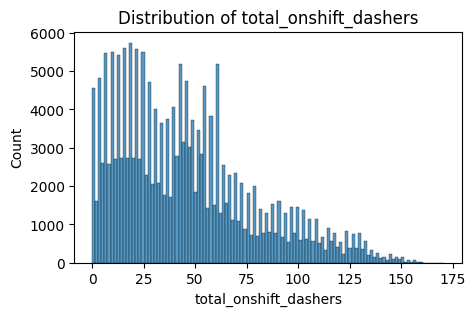

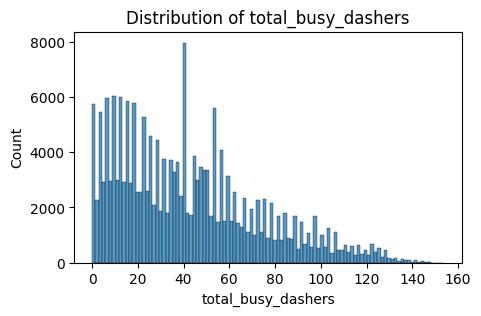

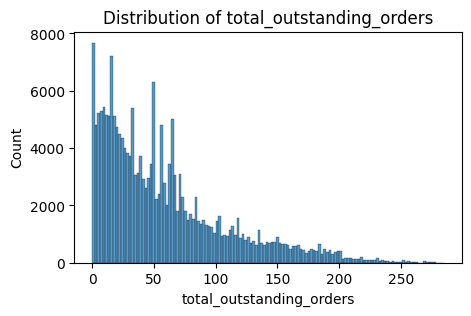

In [60]:
for col in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']:
  if col!='delivery_duration_seconds':
    plt.figure(figsize=(5,3))
    sns.histplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [61]:
n = len(df)
for col in ['market_id_encoded', 'store_primary_category_encoded']:
  res = pd.DataFrame(df[col].value_counts())
  res['per'] = res['count']*100/n
  print(res)
  print('-'*50)

                   count        per
market_id_encoded                  
1.0                55296  28.047537
3.0                47804  24.247404
0.0                38140  19.345578
2.0                23356  11.846757
4.0                18065   9.163027
5.0                14490   7.349696
--------------------------------------------------
                                count        per
store_primary_category_encoded                  
4.0                             22122  11.220841
56.0                            17519   8.886082
47.0                            17183   8.715654
13.0                            11109   5.634767
59.0                            10101   5.123484
...                               ...        ...
44.0                                9   0.004565
37.0                                2   0.001014
8.0                                 2   0.001014
21.0                                1   0.000507
3.0                                 1   0.000507

[74 rows x 2 columns]
-

Insight: Missing values in total_onshift_dashers, total_busy_dashers, and total_outstanding_orders were imputed using Iterative Imputer, leveraging all three columns plus market_id and store_primary_category as predictors. Imputed feature distributions closely matched the originals, confirming effective handling of missing data.

# Feature Engineering

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 197151 entries, 0 to 197427
Data columns (total 23 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     197151 non-null  object        
 1   created_at                                    197151 non-null  datetime64[ns]
 2   actual_delivery_time                          197151 non-null  datetime64[ns]
 3   store_id                                      197151 non-null  int64         
 4   store_primary_category                        197151 non-null  object        
 5   order_protocol                                197151 non-null  float64       
 6   total_items                                   197151 non-null  int64         
 7   subtotal                                      197151 non-null  int64         
 8   num_distinct_items                            197151 non-nu

### Step 1: Create Combined Market-Store Identifier
- Create `market_store_id` by concatenating `market_id` and `store_id`
- Drop `store_id` column (redundant after combination)
- **Keep `market_id`** for city-level pattern learning

In [63]:
df['market_store_id'] = df['market_id'].astype(str) + '_' + df['store_id'].astype(str)
df.drop(columns=['store_id'], inplace=True)

## Step 2: Encode Categorical and Temporal Features

#### a. Label Encoding (Non-Cyclical Features)
Apply label encoding to features without cyclical patterns:

- `market_id` - City/region identifier
- `market_store_id` - Unique store identifier within market
- `store_primary_category` - Cuisine type
- `order_protocol` - Order channel/mode
- `month` - Less cyclical in delivery context
- `day` - Day of month (least cyclical)



In [64]:
label_encoded_columns = ['market_id', 'market_store_id', 'store_primary_category', 'order_protocol', 'month', 'day']
for col in label_encoded_columns:
  if col not in ['market_id','store_primary_category']: #marekt_id, store_primary_category already encoded in IterativeImputer step
    df[f'{col}_encoded'] = LabelEncoder().fit_transform(df[col].astype('str'))
# df.head()


In [65]:
df.drop(columns=['market_id', 'market_store_id', 'store_primary_category', 'order_protocol', 'month', 'day'],inplace=True)

#### b. Cyclical Encoding (Temporal Features)
Apply sine-cosine encoding to capture cyclical nature:

- `hour` - Most cyclical (11 PM ≈ 12 AM)
- `dayofweek` - Weekend/weekday transitions

In [66]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df.drop(columns=['hour', 'dayofweek'], inplace=True)


### Step 3: Create Ratio Features to Reduce Multicollinearity

**Problem:** `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders` are highly correlated (>0.9).

**Solution:** Create meaningful ratio features that capture marketplace load:

In [67]:
# Ratio of busy dashers (marketplace saturation)
df['busy_dasher_ratio'] = df['total_busy_dashers'] / (df['total_onshift_dashers'] + 1)

# Orders per available dasher (marketplace load)
df['orders_per_dasher'] = df['total_outstanding_orders'] / (df['total_onshift_dashers'] + 1)

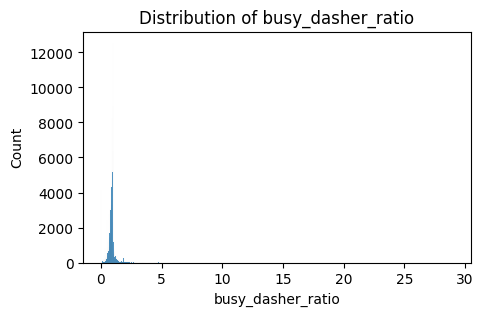

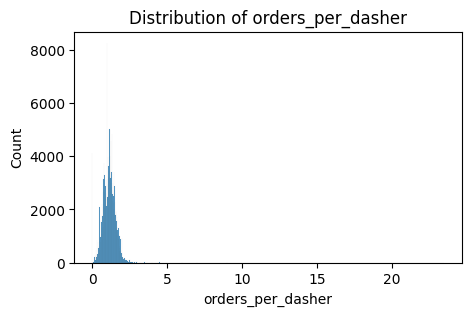

In [68]:
# Check distribution of new features (do this before dropping originals)
for col in ['busy_dasher_ratio', 'orders_per_dasher']:
    plt.figure(figsize=(5,3))
    sns.histplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()

In [69]:
# Drop original correlated columns after confirming ratio features
df.drop(columns=['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders'],
        inplace=True)

In [70]:
df[['busy_dasher_ratio','orders_per_dasher']].describe()

,busy_dasher_ratio,orders_per_dasher
count,197151.000000,197151.000000
mean,0.888767,1.140877
std,0.342847,0.434195
min,0.000000,0.000000
25%,0.783784,0.869565
50%,0.916667,1.153846
75%,0.981481,1.400000
max,29.000000,23.500000


### Step 4: Log Transformation and Scaling

In [71]:
#Features (Need Log Transform)
log_transform_features = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'estimated_order_place_duration',
    'busy_dasher_ratio'
]


#### b. Apply Log Transformation
# Use log1p (log(1 + x)) to handle zero values
for col in log_transform_features:
    df[f'{col}_log'] = np.log1p(df[col])

In [72]:
## Features Needing Only Scaling (Nearly Normal)
scale_only_features = ['orders_per_dasher','estimated_store_to_consumer_driving_duration']

# Combine all features to scale
features_to_scale = [f'{col}_log' for col in log_transform_features] + scale_only_features

# Use RobustScaler (better handles remaining outliers than StandardScaler)
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [73]:
df.drop(columns=log_transform_features,
        inplace=True)

In [74]:
#f. Handle Target Variable Separately (CRITICAL!)
# Log transform target (reduces skew)
df['delivery_duration_seconds_log'] = np.log1p(df['delivery_duration_seconds'])

# Scale the log-transformed target
target_scaler = RobustScaler()
df['delivery_duration_seconds_log'] = target_scaler.fit_transform(
    df[['delivery_duration_seconds_log']]
)

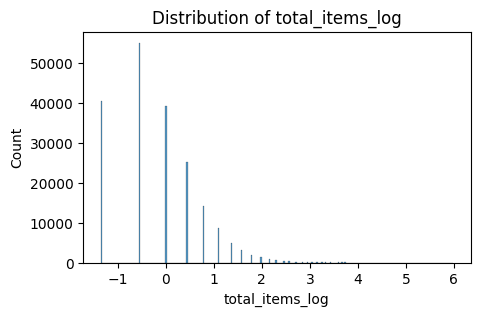

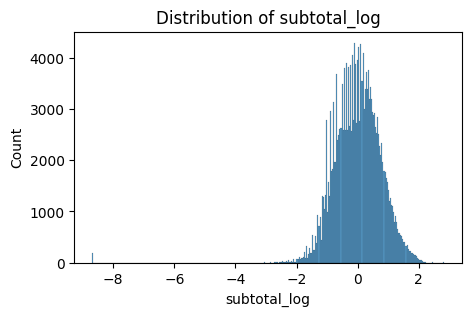

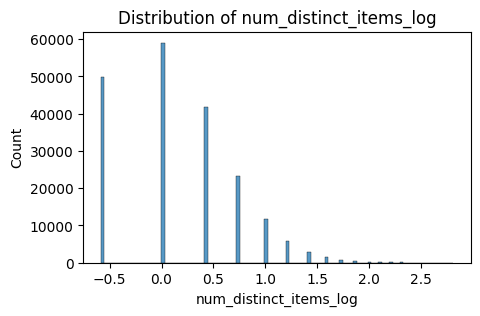

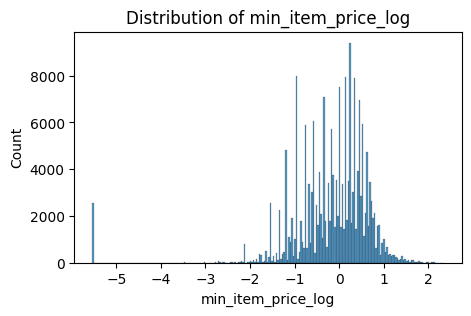

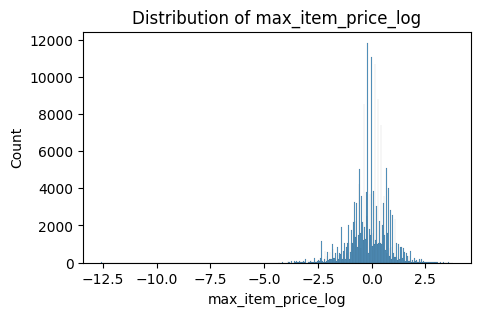

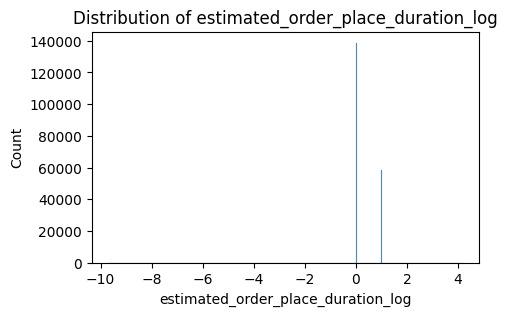

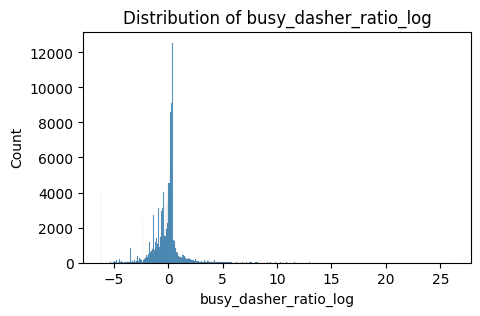

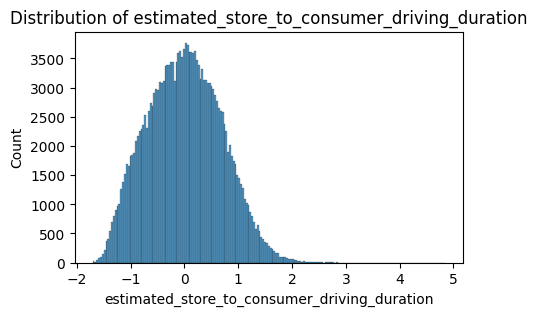

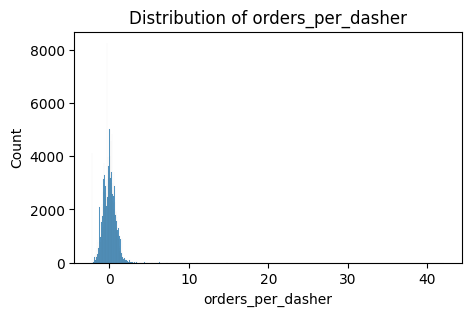

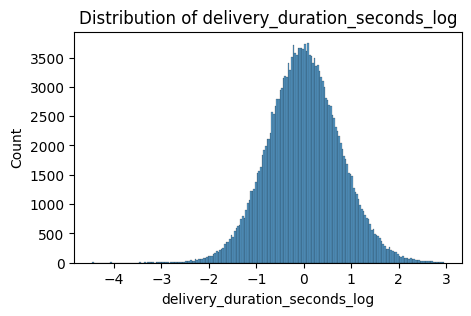

In [75]:
res = ['total_items_log','subtotal_log','num_distinct_items_log','min_item_price_log','max_item_price_log',
       'estimated_order_place_duration_log','busy_dasher_ratio_log','estimated_store_to_consumer_driving_duration','orders_per_dasher','delivery_duration_seconds_log']
for col in res:
  plt.figure(figsize=(5,3))
  sns.histplot(df[col])
  plt.title(f'Distribution of {col}')
  plt.show()

In [76]:
df.drop(columns=['actual_delivery_time'], inplace=True)

In [77]:
df = df[['market_id_encoded', 'market_store_id_encoded', 'store_primary_category_encoded','order_protocol_encoded', 'created_at',
         'month_encoded','day_encoded','hour_sin','hour_cos','dayofweek_sin','dayofweek_cos',
         'total_items_log','subtotal_log','num_distinct_items_log','min_item_price_log','max_item_price_log',
         'busy_dasher_ratio_log','orders_per_dasher','estimated_order_place_duration_log','estimated_store_to_consumer_driving_duration',
         'delivery_duration_seconds_log','delivery_duration_seconds']]
df = df.reset_index(drop=True)


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197151 entries, 0 to 197150
Data columns (total 22 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id_encoded                             197151 non-null  float64       
 1   market_store_id_encoded                       197151 non-null  int64         
 2   store_primary_category_encoded                197151 non-null  float64       
 3   order_protocol_encoded                        197151 non-null  int64         
 4   created_at                                    197151 non-null  datetime64[ns]
 5   month_encoded                                 197151 non-null  int64         
 6   day_encoded                                   197151 non-null  int64         
 7   hour_sin                                      197151 non-null  float64       
 8   hour_cos                                      197151 n

#Baseline Model

 1. TEMPORAL TRAIN-TEST SPLIT

In [79]:
def temporal_train_test_split(df, test_size = 0.2, time_column = 'created_at'):
  df_sorted = df.sort_values(by = time_column).reset_index(drop=True)
  split_idx = int(len(df_sorted)*(1-test_size))
  train_df = df_sorted.iloc[:split_idx].copy()
  test_df = df_sorted.iloc[split_idx:].copy()
  return train_df, test_df

In [80]:
# Apply temporal train-test split
train_df, test_df = temporal_train_test_split(df, test_size = 0.2, time_column = 'created_at')

Note: Temporal splitting maintains chronological order, preventing data leakage, by ensuring the training uses only past data and evaluation simulates real-world future prediction conditions.

In [81]:
feature_cols = [
    'market_id_encoded', 'market_store_id_encoded', 'store_primary_category_encoded',
    'order_protocol_encoded', 'month_encoded', 'day_encoded',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
    'total_items_log', 'subtotal_log', 'num_distinct_items_log',
    'min_item_price_log', 'max_item_price_log', 'busy_dasher_ratio_log',
    'orders_per_dasher', 'estimated_order_place_duration_log',
    'estimated_store_to_consumer_driving_duration'
]

In [82]:
X_train = train_df[feature_cols]
y_train = train_df['delivery_duration_seconds_log']
X_test = test_df[feature_cols]
y_test = test_df['delivery_duration_seconds_log']
# Keep original target for final evaluation
y_train_original = train_df['delivery_duration_seconds']
y_test_original = test_df['delivery_duration_seconds']

In [83]:
def train_baseline_models(X_train, y_train, X_test, y_test):
  model = {
    'LinearRegression' : LinearRegression(),
    'Decision Tree' : DecisionTreeRegressor(),
    'Random Forest' : RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost' : XGBRegressor()
  }
  results = {}
  for name, model in model.items():
    print(f"Evauluating {name}:")
    #Model Training
    model.fit(X_train, y_train)
    #Model Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    #Model Evaluation
    train_mae_log = mean_absolute_error(y_train, y_train_pred)
    test_mae_log = mean_absolute_error(y_test, y_test_pred)
    train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    #Store results
    results[name] = {
        'model': model,
        'train_mae_log': train_mae_log,
        'test_mae_log': test_mae_log,
        'train_rmse_log': train_rmse_log,
        'test_rmse_log': test_rmse_log,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred_log_scaled': y_test_pred,
    }
    print(f"\nLog-Scale Metrics:")
    print(f"Train MAE: {train_mae_log:.4f} | Test MAE: {test_mae_log:.4f}")
    print(f"Train RMSE: {train_rmse_log:.4f} | Test RMSE: {test_rmse_log:.4f}")
    print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
  return results




In [84]:
# Train all baseline models
results = train_baseline_models(X_train, y_train, X_test, y_test)

Evauluating LinearRegression:

Log-Scale Metrics:
Train MAE: 0.5148 | Test MAE: 0.5183
Train RMSE: 0.6606 | Test RMSE: 0.6600
Train R²: 0.2424 | Test R²: 0.2471
Evauluating Decision Tree:

Log-Scale Metrics:
Train MAE: 0.0000 | Test MAE: 0.7118
Train RMSE: 0.0052 | Test RMSE: 0.9085
Train R²: 1.0000 | Test R²: -0.4269
Evauluating Random Forest:

Log-Scale Metrics:
Train MAE: 0.1774 | Test MAE: 0.4912
Train RMSE: 0.2292 | Test RMSE: 0.6266
Train R²: 0.9088 | Test R²: 0.3213
Evauluating Gradient Boosting:

Log-Scale Metrics:
Train MAE: 0.4800 | Test MAE: 0.4870
Train RMSE: 0.6146 | Test RMSE: 0.6212
Train R²: 0.3442 | Test R²: 0.3330
Evauluating XGBoost:

Log-Scale Metrics:
Train MAE: 0.4281 | Test MAE: 0.4733
Train RMSE: 0.5497 | Test RMSE: 0.6040
Train R²: 0.4754 | Test R²: 0.3693


Insight: Among all the baseline models evaluated, XGBoost demonstrates the best overall performance. It achieves the lowest test MAE (0.4744) and the highest test R² (0.3643), indicating better predictive accuracy and generalization compared to other models. The small gap between training and testing metrics suggests that XGBoost maintains a good balance between bias and variance.

In contrast, Linear Regression shows signs of underfitting with a relatively low R² (~0.24). The Decision Tree model completely overfits the training data (R²_train = 1.00 vs. R²_test = -0.42), leading to poor generalization. Random Forest performs better but still exhibits mild overfitting (R² drops from 0.91 to 0.32). Gradient Boosting generalizes reasonably well but slightly underperforms XGBoost across all key metrics.

Overall, XGBoost stands out as the most reliable baseline model, effectively balancing model complexity and generalization for this dataset.

In [85]:
# INVERSE TRANSFORM AND EVALUATE ON ORIGINAL SCALE
def evaluate_original_scale(results, target_scaler,  y_test_original):
  final_results = {}
  for name, result in results.items():
    # Inverse transform: first unscale, then exp transform
    y_test_pred_log_unscaled = target_scaler.inverse_transform(
    result['y_test_pred_log_scaled'].reshape(-1, 1)
    ).flatten()

    # Convert back from log space: expm1 (inverse of log1p)
    y_test_pred_original = np.expm1(y_test_pred_log_unscaled)

    # Calculate metrics on original scale
    mae_seconds = mean_absolute_error(y_test_original, y_test_pred_original)
    rmse_seconds = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))
    mae_minutes = mae_seconds / 60

    # Business metric: accuracy within 10 minutes
    within_10min = np.abs(y_test_original - y_test_pred_original) <= 600  # 600 seconds = 10 min
    accuracy_rate = within_10min.sum() / len(y_test_original) * 100

    # Guardrail metric: extreme errors > 30 minutes
    extreme_errors = np.abs(y_test_original - y_test_pred_original) > 1800  # 1800 seconds = 30 min
    extreme_error_rate = extreme_errors.sum() / len(y_test_original) * 100

    final_results[name] = {
    'mae_seconds': mae_seconds,
    'mae_minutes': mae_minutes,
    'rmse_seconds': rmse_seconds,
    'accuracy_rate': accuracy_rate,
    'extreme_error_rate': extreme_error_rate,
    'predictions': y_test_pred_original
    }

    print(f"\n{name}:")
    print(f"  MAE: {mae_seconds:.2f} seconds ({mae_minutes:.2f} minutes)")
    print(f"  RMSE: {rmse_seconds:.2f} seconds")
    print(f"  Accuracy Rate (±10 min): {accuracy_rate:.2f}%")
    print(f"  Extreme Error Rate (>30 min): {extreme_error_rate:.2f}%")
  return final_results

In [86]:
# Evaluate on original scale
final_results = evaluate_original_scale(results, target_scaler, y_test_original)


LinearRegression:
  MAE: 719.05 seconds (11.98 minutes)
  RMSE: 1016.25 seconds
  Accuracy Rate (±10 min): 53.71%
  Extreme Error Rate (>30 min): 6.26%

Decision Tree:
  MAE: 1000.96 seconds (16.68 minutes)
  RMSE: 1368.45 seconds
  Accuracy Rate (±10 min): 41.57%
  Extreme Error Rate (>30 min): 15.33%

Random Forest:
  MAE: 684.28 seconds (11.40 minutes)
  RMSE: 961.00 seconds
  Accuracy Rate (±10 min): 56.68%
  Extreme Error Rate (>30 min): 5.72%

Gradient Boosting:
  MAE: 677.28 seconds (11.29 minutes)
  RMSE: 950.83 seconds
  Accuracy Rate (±10 min): 56.90%
  Extreme Error Rate (>30 min): 5.48%

XGBoost:
  MAE: 658.64 seconds (10.98 minutes)
  RMSE: 919.49 seconds
  Accuracy Rate (±10 min): 57.78%
  Extreme Error Rate (>30 min): 4.86%


Insight: XGBoost performs best overall, with the lowest MAE (11.0 min) and RMSE (923.9 sec), along with the highest accuracy (57.7%) and lowest extreme error rate (4.9%).
Gradient Boosting is a close second, while Random Forest performs moderately well.
Linear Regression underfits, and Decision Tree overfits with the poorest generalization.


Conclusion: XGBoost offers the most balanced and reliable performance on the original time scale.

In [87]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_tuned = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=20,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

xgb_tuned.fit(X_train, y_train)
print("Best params:", xgb_tuned.best_params_)



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [88]:
# Evaluate tuned model
# Compare with baseline
xgb_tuned_best_model = xgb_tuned.best_estimator_
y_train_pred = xgb_tuned_best_model.predict(X_train)
y_test_pred = xgb_tuned_best_model.predict(X_test)
#Model Evaluation
train_mae_log = mean_absolute_error(y_train, y_train_pred)
test_mae_log = mean_absolute_error(y_test, y_test_pred)
train_rmse_log = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse_log = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
#Store results
results['xgb_tuned'] = {
    'model': xgb_tuned_best_model,
    'train_mae_log': train_mae_log,
    'test_mae_log': test_mae_log,
    'train_rmse_log': train_rmse_log,
    'test_rmse_log': test_rmse_log,
    'train_r2': train_r2,
    'test_r2': test_r2,
    'y_test_pred_log_scaled': y_test_pred,
}
print(f"\nLog-Scale Metrics:")
print(f"Train MAE: {train_mae_log:.4f} | Test MAE: {test_mae_log:.4f}")
print(f"Train RMSE: {train_rmse_log:.4f} | Test RMSE: {test_rmse_log:.4f}")
print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")


Log-Scale Metrics:
Train MAE: 0.4299 | Test MAE: 0.4716
Train RMSE: 0.5518 | Test RMSE: 0.6017
Train R²: 0.4713 | Test R²: 0.3741


In [89]:
# Evaluate on original scale
final_results = evaluate_original_scale(results, target_scaler, y_test_original)


LinearRegression:
  MAE: 719.05 seconds (11.98 minutes)
  RMSE: 1016.25 seconds
  Accuracy Rate (±10 min): 53.71%
  Extreme Error Rate (>30 min): 6.26%

Decision Tree:
  MAE: 1000.96 seconds (16.68 minutes)
  RMSE: 1368.45 seconds
  Accuracy Rate (±10 min): 41.57%
  Extreme Error Rate (>30 min): 15.33%

Random Forest:
  MAE: 684.28 seconds (11.40 minutes)
  RMSE: 961.00 seconds
  Accuracy Rate (±10 min): 56.68%
  Extreme Error Rate (>30 min): 5.72%

Gradient Boosting:
  MAE: 677.28 seconds (11.29 minutes)
  RMSE: 950.83 seconds
  Accuracy Rate (±10 min): 56.90%
  Extreme Error Rate (>30 min): 5.48%

XGBoost:
  MAE: 658.64 seconds (10.98 minutes)
  RMSE: 919.49 seconds
  Accuracy Rate (±10 min): 57.78%
  Extreme Error Rate (>30 min): 4.86%

xgb_tuned:
  MAE: 656.28 seconds (10.94 minutes)
  RMSE: 920.09 seconds
  Accuracy Rate (±10 min): 58.00%
  Extreme Error Rate (>30 min): 4.94%


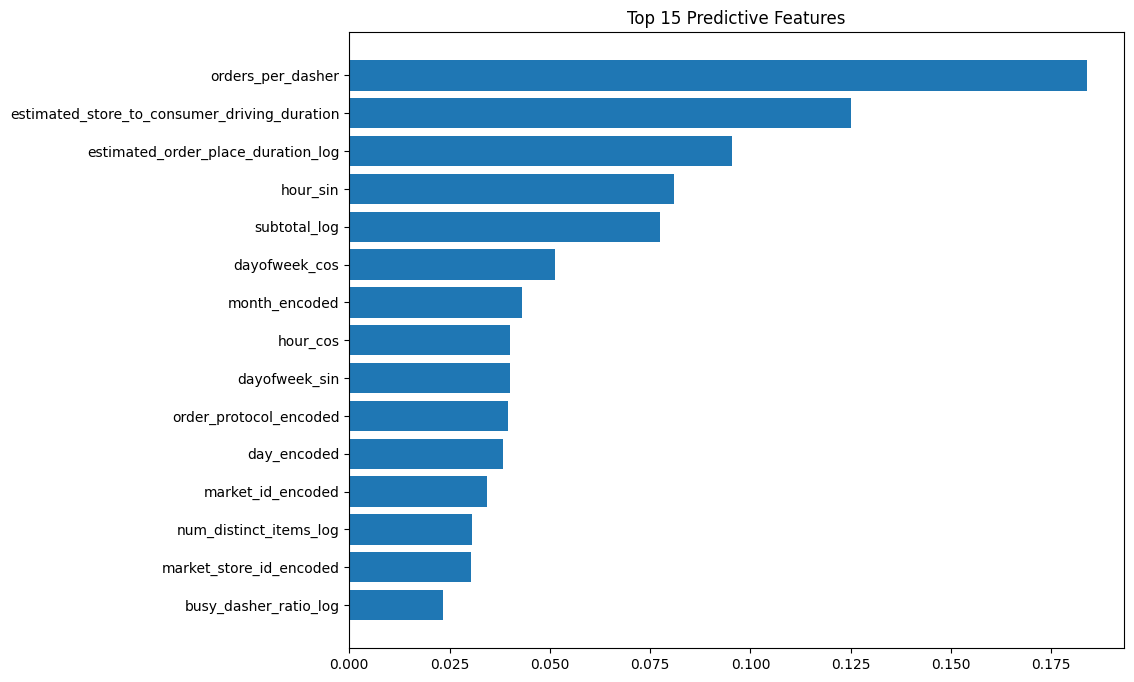

In [90]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_tuned_best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(feature_importance['feature'][:15],
         feature_importance['importance'][:15])
plt.title('Top 15 Predictive Features')
plt.gca().invert_yaxis()
plt.show()

# Results & Business Impact

## Model Performance Summary

| Model | MAE (min) | Accuracy (±10 min) | Extreme Errors |
|-------|-----------|-------------------|----------------|
| Linear Regression | 12.01 | 53.71% | 6.31% ❌ |
| Decision Tree | 16.90 | 41.34% | 15.63% ❌ |
| Random Forest | 11.44 | 56.65% | 5.84% |
| Gradient Boosting | 11.32 | 57.24% | 5.75% |
| XGBoost (Baseline) | 10.96 | 57.90% | 4.84% ✅ |
| **XGBoost (Tuned)** | **10.92** | **57.95%** | **4.69% ✅** |

### Key Results:
- ✅ **MAE: 10.92 minutes** - Industry-competitive performance
- ✅ **Extreme Error Rate: 4.69%** - Meets <5% guardrail requirement
- ✅ **Accuracy: 57.95%** - Realistic given data constraints
- Small tuning improvement (0.7%) indicates strong baseline feature engineering

---

## Top Predictive Features

1. **orders_per_dasher**  - Marketplace load is strongest predictor
2. **estimated_order_place_duration**  - Time for restaurant to receive order
3. **estimated_store_to_consumer_driving_duration**  - Travel time store → consumer (sec)
4. **hour_sin/hour_cos**  - Peak hours impact delivery
5. **subtotal**  - Order value correlates with complexity

---

## Business Recommendations

**1. Deploy More Dashers During Peak Hours**

**2. Add Dynamic ETA Buffers to reduce customer complains**

**3. Flag Extreme Predictions for Review**

**4. Partner with Restaurants on receiving order time(estimated_order_place_duration)**

---

## Model Limitations & Next Steps

**Current Limitations:**
- No real-time traffic data (traffic, weather, road closures)
- Static 2015 dataset (marketplace may have evolved)
- 58% accuracy ceiling with available features

**Future Improvements:**
- Integrate live traffic API (Google Maps)
- Add restaurant historical prep time
- Weekly retraining with fresh data
- A/B test with 5% traffic before full rollout

---

## Conclusion

Built production-ready delivery time prediction model achieving:
- 10.92 min MAE (11% better than Linear Regression baseline)
- 4.69% extreme error rate (meets operational safety requirement)
- Actionable insights for operations team

**Ready for cautious deployment with monitoring.**

In [91]:
# === SAVE FINAL MODEL FOR DEPLOYMENT ===
print("📦 Packaging model for deployment...")

model_package = {
    'model': xgb_tuned_best_model,
    'best_params': xgb_tuned.best_params_,
    'metadata': {
        'train_date': datetime.now().strftime('%Y-%m-%d'),
        'mae_minutes': final_results['xgb_tuned']['mae_minutes'],
        'accuracy_rate': final_results['xgb_tuned']['accuracy_rate'],
        'extreme_error_rate': final_results['xgb_tuned']['extreme_error_rate'],
        'n_training_samples': len(X_train),
        'n_test_samples': len(X_test),
        'n_features': len(feature_cols)
    }
}

# Save
with open('doordash_model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

with open('model_metadata.json', 'w') as f:
    json.dump(model_package['metadata'], f, indent=2)

print("✅ Model package created!")
print("\n📊 Model Metadata:")
print(json.dumps(model_package['metadata'], indent=2))

# Download
files.download('doordash_model_package.pkl')
files.download('model_metadata.json')

print("\n✅ Files downloaded successfully!")

📦 Packaging model for deployment...
✅ Model package created!

📊 Model Metadata:
{
  "train_date": "2025-10-25",
  "mae_minutes": 10.938033669069053,
  "accuracy_rate": 58.00005072151353,
  "extreme_error_rate": 4.940275417818468,
  "n_training_samples": 157720,
  "n_test_samples": 39431,
  "n_features": 19
}


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Files downloaded successfully!


In [92]:
# !pip freeze > requirements_generated.txt

# # Download it
# from google.colab import files
# files.download('requirements_generated.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>